**Pre-processing the data:**


In [0]:
###------PREPROCESSING THE DATA-------------
import json
import pickle
import time
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 

default_pattern =  r"""(?x)                  
                        (?:[A-Z]\.)+          
                        |\$?\d+(?:\.\d+)?%?    
                        |\w+(?:[-']\w+)*      
                    """
with open('train.json') as json_file:
    data = json.load(json_file)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def prepare_data(start, data_length):
  #data_length = 20000

  essays = []
  age = []
  gender = []
  gender_label  = []
  age_label = []
  original_data = []

  for i in range(start, start+data_length):
    poster_gender = data[i]['gender']
    poster_age = int(data[i]['age'])
    post = data[i]['post']
    original_data.append(post)
    tokens = regexp_tokenize(post, default_pattern)

  #f_post = [w for w in tokens if not w in stop_words]

    essays.append(tokens)
    age.append(poster_age)
    gender.append(poster_gender)
    if poster_gender == 'male':
      gender_label.append(0)
    else:
      gender_label.append(1)
    if poster_age <= 15:
      age_label.append(0)
    elif poster_age > 15 and poster_age <= 25:
      age_label.append(1)
    elif poster_age > 25 and poster_age <= 35:
      age_label.append(2)
    elif poster_age > 35 and poster_age <= 50:
      age_label.append(3)
      
  return essays, gender_label, age_label, original_data

In [0]:
def prepare_test(data):
  essays = []
  for i in range(len(data)):
    if data[i] == []:
      continue
    tokens = regexp_tokenize(data[i], default_pattern)
    essays.append(tokens)
  return essays

**Dataset summary:**

In [0]:
def gender_summary(essays, gender_label, mcount, fcount, ecount, avg_size):
  for idx in range(len(essays)):
    if gender_label[idx] == 0:
      mcount += 1
    elif gender_label[idx] == 1:
      fcount += 1
    avg_size += len(essays[idx])
  ecount += len(essays)
  return mcount, fcount, ecount, avg_size

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

male_no = 0
female_no = 0
doc_size = 0

for idx in range(len(essays)):
  if gender_label[idx] == 0:
    male_no += 1
  elif gender_label[idx] == 1:
    female_no += 1
  doc_size += len(essays[idx])

avg_doc_size = doc_size/len(essays)

print('Data summary for gender prediction task')
print('Number of male writers:', male_no)
print('Number of female writers:', female_no)
print('Number of essays used:', len(essays))
print('Average document size:', avg_doc_size, 'words')
print('Unique number of labels:', 2)

print('\n')
print('Post no Essay                          Gender')
for idx in range(1, 5):
  o = original_data[idx]
  if gender_label[idx] == 0:
    g = 'male'
  else:
    g = 'female'
  print(idx,'      ', o[:28], g)


Data summary for gender prediction task
Number of male writers: 10226
Number of female writers: 9774
Number of essays used: 20000
Average document size: 206.4144 words
Unique number of labels: 2


Post no Essay                          Gender
1        so wuts up? today i had the  male
2        i don't know about anyone el female
3        urlLink    another roof-top  male
4        gawd i luv my nanny!  she's  female


In [0]:
batches = []
i = 0
while i < 250000:
  batches.append(i)
  i += 20000

mcount = 0
fcount = 0
ecount = 0
avg_size = 0
for i in batches:
  essays, gender_label, age_label, original_data = prepare_data(i, 20000)
  mcount, fcount, ecount, avg_size = gender_summary(essays, gender_label, mcount,fcount,ecount,avg_size)

print('Data summary for gender prediction task')
print('Number of male writers:', mcount/ecount)
print('Number of female writers:', fcount/ecount)
print('Number of essays used:', ecount)
print('Average document size:', avg_size/ecount, 'words')
print('Unique number of labels:', 2)

print('\n')
print('Post no Essay                          Gender')
for idx in range(10, 15):
  o = original_data[idx]
  if gender_label[idx] == 0:
    g = 'male'
  else:
    g = 'female'
  print(idx,'      ', o[:28],'  ', g)

Data summary for gender prediction task
Number of male writers: 0.5094961538461539
Number of female writers: 0.4905038461538462
Number of essays used: 260000
Average document size: 204.52252307692308 words
Unique number of labels: 2


Post no Essay                          Gender
10        Only one more day...woo hoo!    female
11        Guess what? I've been throug    male
12        The psuedonym (or how ever t    male
13        I cannot focus. I have a sci    female
14        Keep On Rockin' In The Free     female


**Visualization functions:**

In [0]:
###----_VISUALIZATION------------
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [0]:
def create_plot(labels, male_means, female_means, title, flag, size, save):
  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  fig.set_size_inches(size, size)
  rects1 = ax.bar(x - width/2, male_means, width, label='Male')
  rects2 = ax.bar(x + width/2, female_means, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Scores')
  ax.set_title(title)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  if flag == 1:
    autolabel(rects1)
    autolabel(rects2)

  if save == 1:
    fig.savefig('test2png.png', dpi=100)

  fig.tight_layout()

  plt.show()

In [0]:
def sparse_plot(A):
  plt.spy(A)

# **Gender profiling**

**Using possessive features**:


In [0]:
###-----CREATING POSSESSIVE FEATURES--------
def possessives_features(posts):
  total_dict = {}
  count_my = {}
  count_others = {}

  index = 0

  for post in posts:
    tag = 0
    for word in post:
      if tag == 1 and word.lower() not in total_dict:
        total_dict[word.lower()] = index
        count_my[word.lower()] = 1
        count_others[word.lower()] = 0
        index += 1
      elif tag == 1 and word.lower() in total_dict:
        count_my[word.lower()] += 1
      elif tag == 2 and word.lower() not in total_dict:
        total_dict[word.lower()] = index
        count_others[word.lower()] = 1
        count_my[word.lower()] = 0
        index += 1
      elif tag == 2 and word.lower() in total_dict:
        count_others[word.lower()] += 1

      if word.lower() == 'my':
        tag = 1
      elif word.lower() == 'theirs' or word.lower() == 'his' or word.lower() == 'hers' or word.lower() == 'yours':
        tag = 2
      else:
        tag = 0
  
  my_feature = []
  other_feature = []
  dict_len = len(total_dict)
  #print('dict len is',dict_len, 'index', index)

  for post in posts:
    tag = 0
    feature1 = np.zeros(dict_len)
    feature2 = np.zeros(dict_len)
    for word in post:
      if tag == 1:
        idx = total_dict[word.lower()]
        feature1[idx] += 1
      elif tag == 2:
        idx = total_dict[word.lower()]
        feature2[idx] += 1

      if word.lower() == 'my':
        tag = 1
      elif word.lower() == 'theirs' or word.lower() == 'his' or word.lower() == 'hers' or word.lower() == 'yours':
        tag = 2
      else:
        tag = 0
    my_feature.append(feature1)
    other_feature.append(feature2)
  return my_feature, other_feature, total_dict

In [0]:
###----SVM WITH POSSESSIVES-----------
import sklearn
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#classifier = svm.SVC(max_iter=5000)
trainlength = round(0.8*20000)
classifier = LogisticRegression(random_state=0, max_iter=1000)

batches = []
i = 0
while i < 250000:
  batches.append(i)
  i += 20000
acc = 0
for i in batches:
  essays, gender_label, age_label, original_data = prepare_data(i, 20000)
  my_feature, other_feature, total_dict = possessives_features(essays)
  features = my_feature
  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(gender_label[:trainlength])

#Xtrain = Xtrain.reshape(-1, 1)

  classifier.fit(Xtrain, Ytrain)
#classifier.fit(Xtrain, Ytrain)
  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)
  #print('done with split')
  pred = classifier.predict(Xtest)
  acc += accuracy_score(Ytest, pred)
  print('Batch', batches.index(i), ':', accuracy_score(Ytest, pred))
print('Overall accuracy:', acc/len(batches))

Batch 0 : 0.5715
Batch 1 : 0.556
Batch 2 : 0.56525
Batch 3 : 0.548
Batch 4 : 0.55675
Batch 5 : 0.566
Batch 6 : 0.56625
Batch 7 : 0.5655
Batch 8 : 0.56025
Batch 9 : 0.56825
Batch 10 : 0.5495
Batch 11 : 0.56275
Batch 12 : 0.56975
Overall accuracy: 0.5619807692307692


In [0]:
###-----KNN WITH POSSESSIVES FEATURES---------
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from sklearn.metrics import accuracy_score

#6000:51, 10000:52.45
num = 10000
labels = gender_label[:num]
data = essays[:num]

my_feature, other_feature, total_dict = possessives_features(data)

length = len(my_feature)
print(length)
trainlength = round(0.8*length)
features = my_feature
Xtrain = np.asarray(features[:trainlength])
Ytrain = np.asarray(labels[:trainlength])

clf = neighbors.KNeighborsClassifier(75)
clf.fit(Xtrain, Ytrain)

Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(labels[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

pred = clf.predict(Xtest)
print(accuracy_score(Ytest, pred))

dict len is 5437 index 5437
10000
0.5245


**Using POS features:**

In [0]:
###-----------CREATING POS FEATURES-------------
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
tagset = nltk.load('help/tagsets/upenn_tagset.pickle')
no_tags = len(tagset.keys())
index = 0
tagdict = {}
for tag in tagset.keys():
  tagdict[tag] = index
  index = index+1

def POS(essays):
  pos_features = []
  for post in essays:
    pos = nltk.pos_tag(post)
    feature = np.zeros(no_tags)
    for elem in pos:
      tag = elem[1]
      index = tagdict[tag]
      feature[index] += 1
    pos_features.append(feature)
  return pos_features


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


works


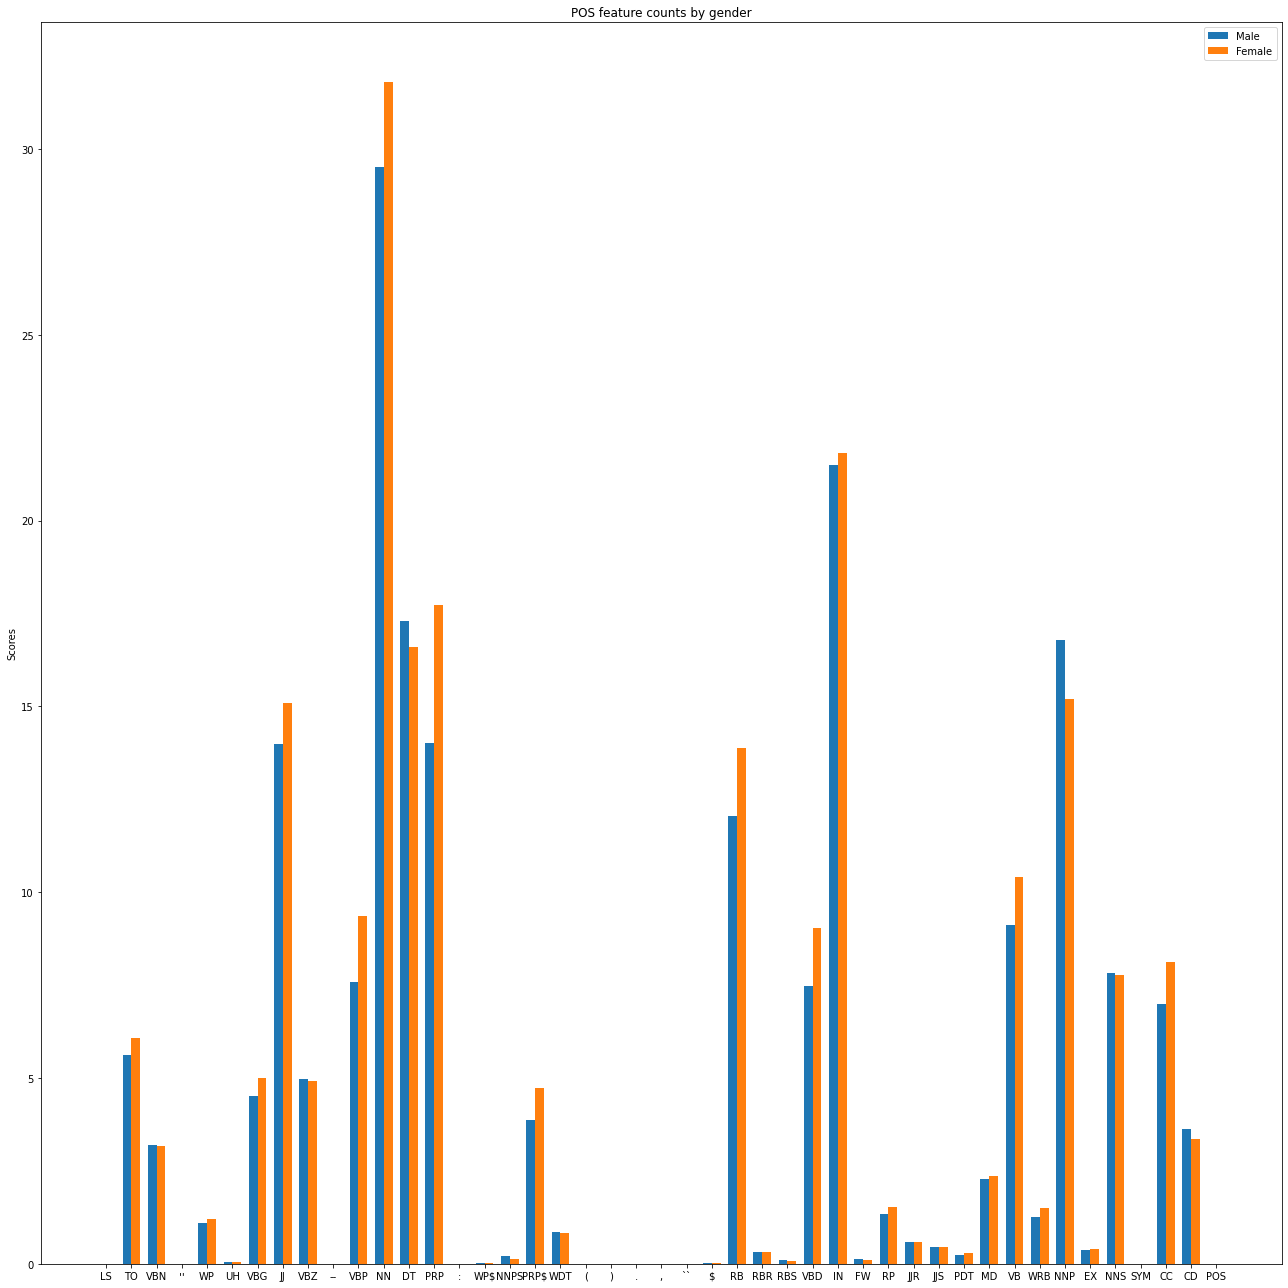

In [0]:
###-------POS FEATURES VISUALIZATION----------
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

labels = []
length = len(tagdict)
male_means = np.zeros(length)
female_means = np.zeros(length)

for label in tagdict:
  labels.append(label)

male_count = 0
female_count = 0
for idx in range(len(essays)):
  if gender_label[idx] == 0: #male
    male_means += np.asarray(pos_features[idx])
    male_count += 1
  else:
    female_means += np.asarray(pos_features[idx])
    female_count += 1

male_means = male_means/male_count
female_means = female_means/female_count

male_means = list(male_means)
female_means = list(female_means)

create_plot(labels, male_means, female_means, 'POS feature counts by gender',1, 18,0)


In [0]:
###------SVM WITH POS_FEATURES-------
import sklearn
from sklearn import svm
from sklearn.metrics import accuracy_score
classifier = svm.SVC(kernel='rbf')
length = 20000
trainlength = round(0.8*length)
acc = 0

batches = []
i = 0
while i < 250000:
  batches.append(i)
  i += 20000

for i in batches:
  essays, gender_label, age_label, original_data = prepare_data(i, 20000)
  pos_features = POS(essays)
  features = pos_features
  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(gender_label[:trainlength])

#Xtrain = Xtrain.reshape(-1, 1)

  classifier.fit(Xtrain, Ytrain)
  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

  pred = classifier.predict(Xtest)
  acc += accuracy_score(Ytest, pred)
  print('Batch', batches.index(i), ':',accuracy_score(Ytest, pred))
print('Overall accuracy', acc/len(batches))

Batch 0 : 0.60375
Batch 1 : 0.57975
Batch 2 : 0.58175
Batch 3 : 0.57875
Batch 4 : 0.57175
Batch 5 : 0.582
Batch 6 : 0.57575
Batch 7 : 0.57825
Batch 8 : 0.579
Batch 9 : 0.58075
Batch 10 : 0.58775
Batch 11 : 0.5855
Batch 12 : 0.586
Overall accuracy 0.5823653846153846


In [0]:
###-----KNN WITH POS_FEATURES---------
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(75)

length = 20000
trainlength = round(0.8*length)
acc = 0

batches = []
i = 0
while i < 250000:
  batches.append(i)
  i += 20000

for i in batches:
  essays, gender_label, age_label, original_data = prepare_data(i, 20000)
  pos_features = POS(essays)
  features = pos_features
  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(gender_label[:trainlength])

  clf.fit(Xtrain, Ytrain)

  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

  pred = clf.predict(Xtest)
  print('Batch', batches.index(i), ':',accuracy_score(Ytest, pred))
  acc += accuracy_score(Ytest, pred)
print('Overall accuracy:', acc/len(batches))

Batch 0 : 0.58725
Batch 1 : 0.572
Batch 2 : 0.564
Batch 3 : 0.57725
Batch 4 : 0.56325
Batch 5 : 0.56475
Batch 6 : 0.57825
Batch 7 : 0.57025
Batch 8 : 0.57925
Batch 9 : 0.58375
Batch 10 : 0.581
Batch 11 : 0.584
Batch 12 : 0.57675
Overall accuracy: 0.5755192307692307


**Using custom-features:**

In [0]:
#f:nn, jj, vbp, rb, vbd, cc
#m:nnp, dt
def custom(pos_features, tagdict):
  c_features = []
  w= [9,10,5,8,6,14,8]

  for feature in pos_features:
    i0 = tagdict['NN']
    i1 = tagdict['JJ']
    i2 = tagdict['VBP']
    i3 = tagdict['VBD']
    i4 = tagdict['CC']

    i5 = tagdict['NNP']
    i6 = tagdict['DT']

    num = w[0]*feature[i0]+w[1]*feature[i1]+w[2]*feature[i2]+w[3]*feature[i3]+w[4]*feature[i4]-w[5]*feature[i5]-w[6]*feature[i6]
    c_features.append(num)
  return c_features

In [0]:
###------SVM WITH CUSTOM FEATURES-------
import sklearn
from sklearn import svm
from sklearn.metrics import accuracy_score

#rbf: 56, linear: 56 , poly:52
#classifier = svm.SVC(kernel='poly')
classifier = svm.LinearSVC(C=1,max_iter=5000,random_state=0, tol=1e-5)
length = 20000
trainlength = round(0.8*length)
acc = 0

batches = []
i = 0
while i < 250000:
  batches.append(i)
  i += 20000

for i in batches:
  essays, gender_label, age_label, original_data = prepare_data(i, 20000)
  pos_features = POS(essays)
  custom_feature = custom(pos_features, tagdict)  
  features = custom_feature

  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(gender_label[:trainlength])

  Xtrain = Xtrain.reshape(-1, 1)

  classifier.fit(Xtrain, Ytrain)
  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(gender_label[trainlength:])

  Xtest = Xtest.reshape(-1, 1)

  pred = classifier.predict(Xtest)
  acc += accuracy_score(Ytest, pred)
  print('Batch', batches.index(i), ':',accuracy_score(Ytest, pred))
print('Overall accuracy:',acc/len(batches))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 0 : 0.538


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 1 : 0.5415


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 2 : 0.547


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 3 : 0.53


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 4 : 0.53225


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 5 : 0.52225


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 6 : 0.53475


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 7 : 0.55775


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 8 : 0.48425


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 9 : 0.47


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 10 : 0.49475


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Batch 11 : 0.478
Batch 12 : 0.4965
Overall accuracy: 0.5174615384615384


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

length = 20000
trainlength = round(0.8*length)
acc = 0
clf = LogisticRegression(C=0.5,random_state=0)

batches = []
i = 0
while i < 250000:
  batches.append(i)
  i += 20000

for i in batches:
  essays, gender_label, age_label, original_data = prepare_data(i, 20000)
  pos_features = POS(essays)
  custom_feature = custom(pos_features, tagdict) 

  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(gender_label[:trainlength])

  Xtrain = Xtrain.reshape(-1, 1)

  clf.fit(Xtrain, Ytrain)

  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(gender_label[trainlength:])

  Xtest = Xtest.reshape(-1, 1)

  pred = classifier.predict(Xtest)
  print('Batch',batches.index(i), ':',accuracy_score(Ytest, pred))
  acc += accuracy_score(Ytest, pred)
print('Overall accuracy:',acc/len(batches))

Batch 0 : 0.5185
Batch 1 : 0.489
Batch 2 : 0.5125
Batch 3 : 0.51425
Batch 4 : 0.51125
Batch 5 : 0.518
Batch 6 : 0.51325
Batch 7 : 0.501
Batch 8 : 0.50475
Batch 9 : 0.51275
Batch 10 : 0.50175
Batch 11 : 0.5055
Batch 12 : 0.4965
Overall accuracy: 0.5076153846153846


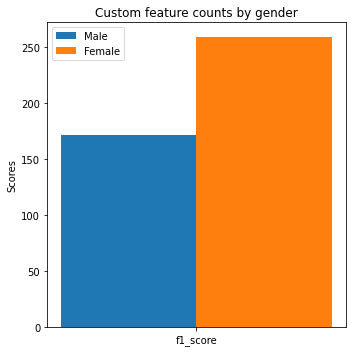

In [0]:
###-------CUSTOM FEATURES VISUALIZATION----------
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

labels = []
male_means = np.zeros(1)
female_means = np.zeros(1)
labels.append('f1_score')

male_count = 0
female_count = 0
for idx in range(len(essays)):
  if gender_label[idx] == 0: #male
    male_means += np.asarray(custom_feature[idx])
    male_count += 1
  else:
    female_means += np.asarray(custom_feature[idx])
    female_count += 1

male_means = male_means/male_count
female_means = female_means/female_count

male_means = list(male_means)
female_means = list(female_means)

create_plot(labels, male_means, female_means, 'Custom feature counts by gender', 0, 5, 0)

**Using f-features:**

In [0]:
###-------CREATING F MEASURE FEATURES-----------
### Reference: https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b
def f(pos_features, tagdict):
  f_features = []
  for feature in pos_features:
    ##NN, NNS, NNP, NNPS
    i0 = tagdict['NN']
    i1 = tagdict['NNS']
    i2 = tagdict['NNP']
    i3 = tagdict['NNPS']
    noun = feature[i0]+feature[i1]+feature[i2]+feature[i3]

    #JJ,JJR,JJS
    i4 = tagdict['JJ']
    i5 = tagdict['JJR']
    i6 = tagdict['JJS']
    adj = feature[i4]+feature[i5]+feature[i6]

    #IN
    i7 = tagdict['IN']
    prep = feature[i7]

    #DT,WDT, PDT(?)
    i8 = tagdict['DT']
    i9 = tagdict['WDT']
    art = feature[i8]+feature[i9]

    #PRP, PRP$
    i10 = tagdict['PRP']
    i11 = tagdict['PRP$']
    pron = feature[i10]+feature[i11]

    #VB,VBD, VBG, VBN, VBP, VBZ
    i12 = tagdict['VB']
    i13 = tagdict['VBD']
    i14 = tagdict['VBN']
    i15 = tagdict['VBP']
    i16 = tagdict['VBZ']
    verb = feature[i12]+feature[i13]+feature[i14]+feature[i15]+feature[i16]

    #RB,RBR,RBS
    i17 = tagdict['RB']
    i18 = tagdict['RBR']
    i19 = tagdict['RBS']
    adv =  feature[i17]+feature[i18]+feature[i19]

    #UH
    i20 = tagdict['UH']
    inter = feature[i20]
    num = 0.5*((noun+adj+prep+art)-(verb+adv+inter)+100)
    f_features.append(num)
  return f_features
f_feature = f(pos_features, tagdict)

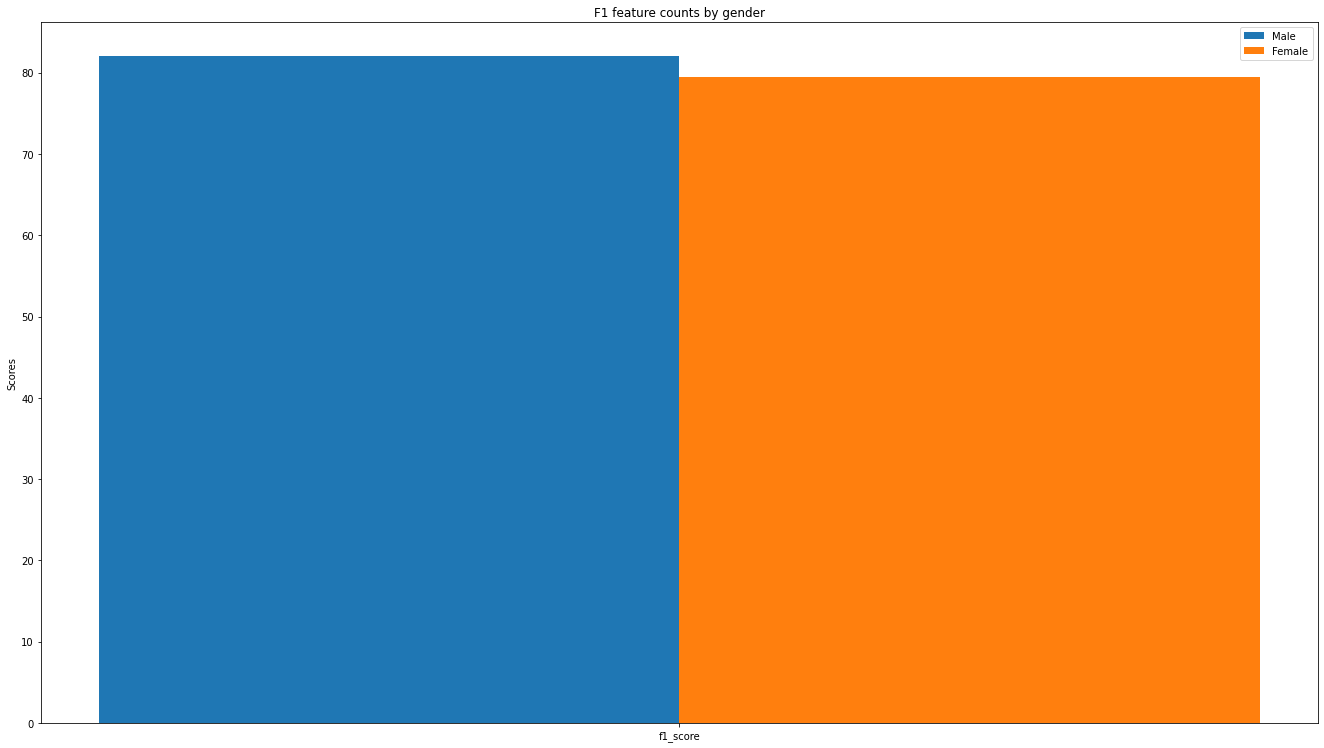

In [0]:
###-------F1 FEATURES VISUALIZATION----------
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

labels = []
male_means = np.zeros(1)
female_means = np.zeros(1)
labels.append('f1_score')

male_count = 0
female_count = 0
for idx in range(len(essays)):
  if gender_label[idx] == 0: #male
    male_means += np.asarray(f_feature[idx])
    male_count += 1
  else:
    female_means += np.asarray(f_feature[idx])
    female_count += 1

male_means = male_means/male_count
female_means = female_means/female_count

male_means = list(male_means)
female_means = list(female_means)

create_plot(labels, male_means, female_means, 'F1 feature counts by gender', 0, 5, 0)

**Using pos-seq (bigram) features:**

In [0]:
###----CREATING POS SEQUENCE FEATURES (Bigram)----------------
index = 0
tagseq = {}
for tag1 in tagset.keys():
  for tag2 in tagset.keys():
    tog = tag1+" "+tag2
    if tog not in tagseq:
      tagseq[tog] = index
      index = index+1

def pos_seq(essays, tagseq):
  pos_seq_features = []
  tagseqlen = len(tagseq)
  for post in essays:
    pos = nltk.pos_tag(post)
    feature = np.zeros(tagseqlen)
    for i in range(len(pos)-1):
      tag1 = pos[i]
      tag2 = pos[i+1]
      tag1 = tag1[1]
      tag2 = tag2[1]
      tog = tag1+" "+tag2
      index = tagseq[tog]
      feature[index] += 1
    pos_seq_features.append(feature)
  return pos_seq_features
  
pos_seq_features = pos_seq(essays, tagseq) 

AttributeError: ignored

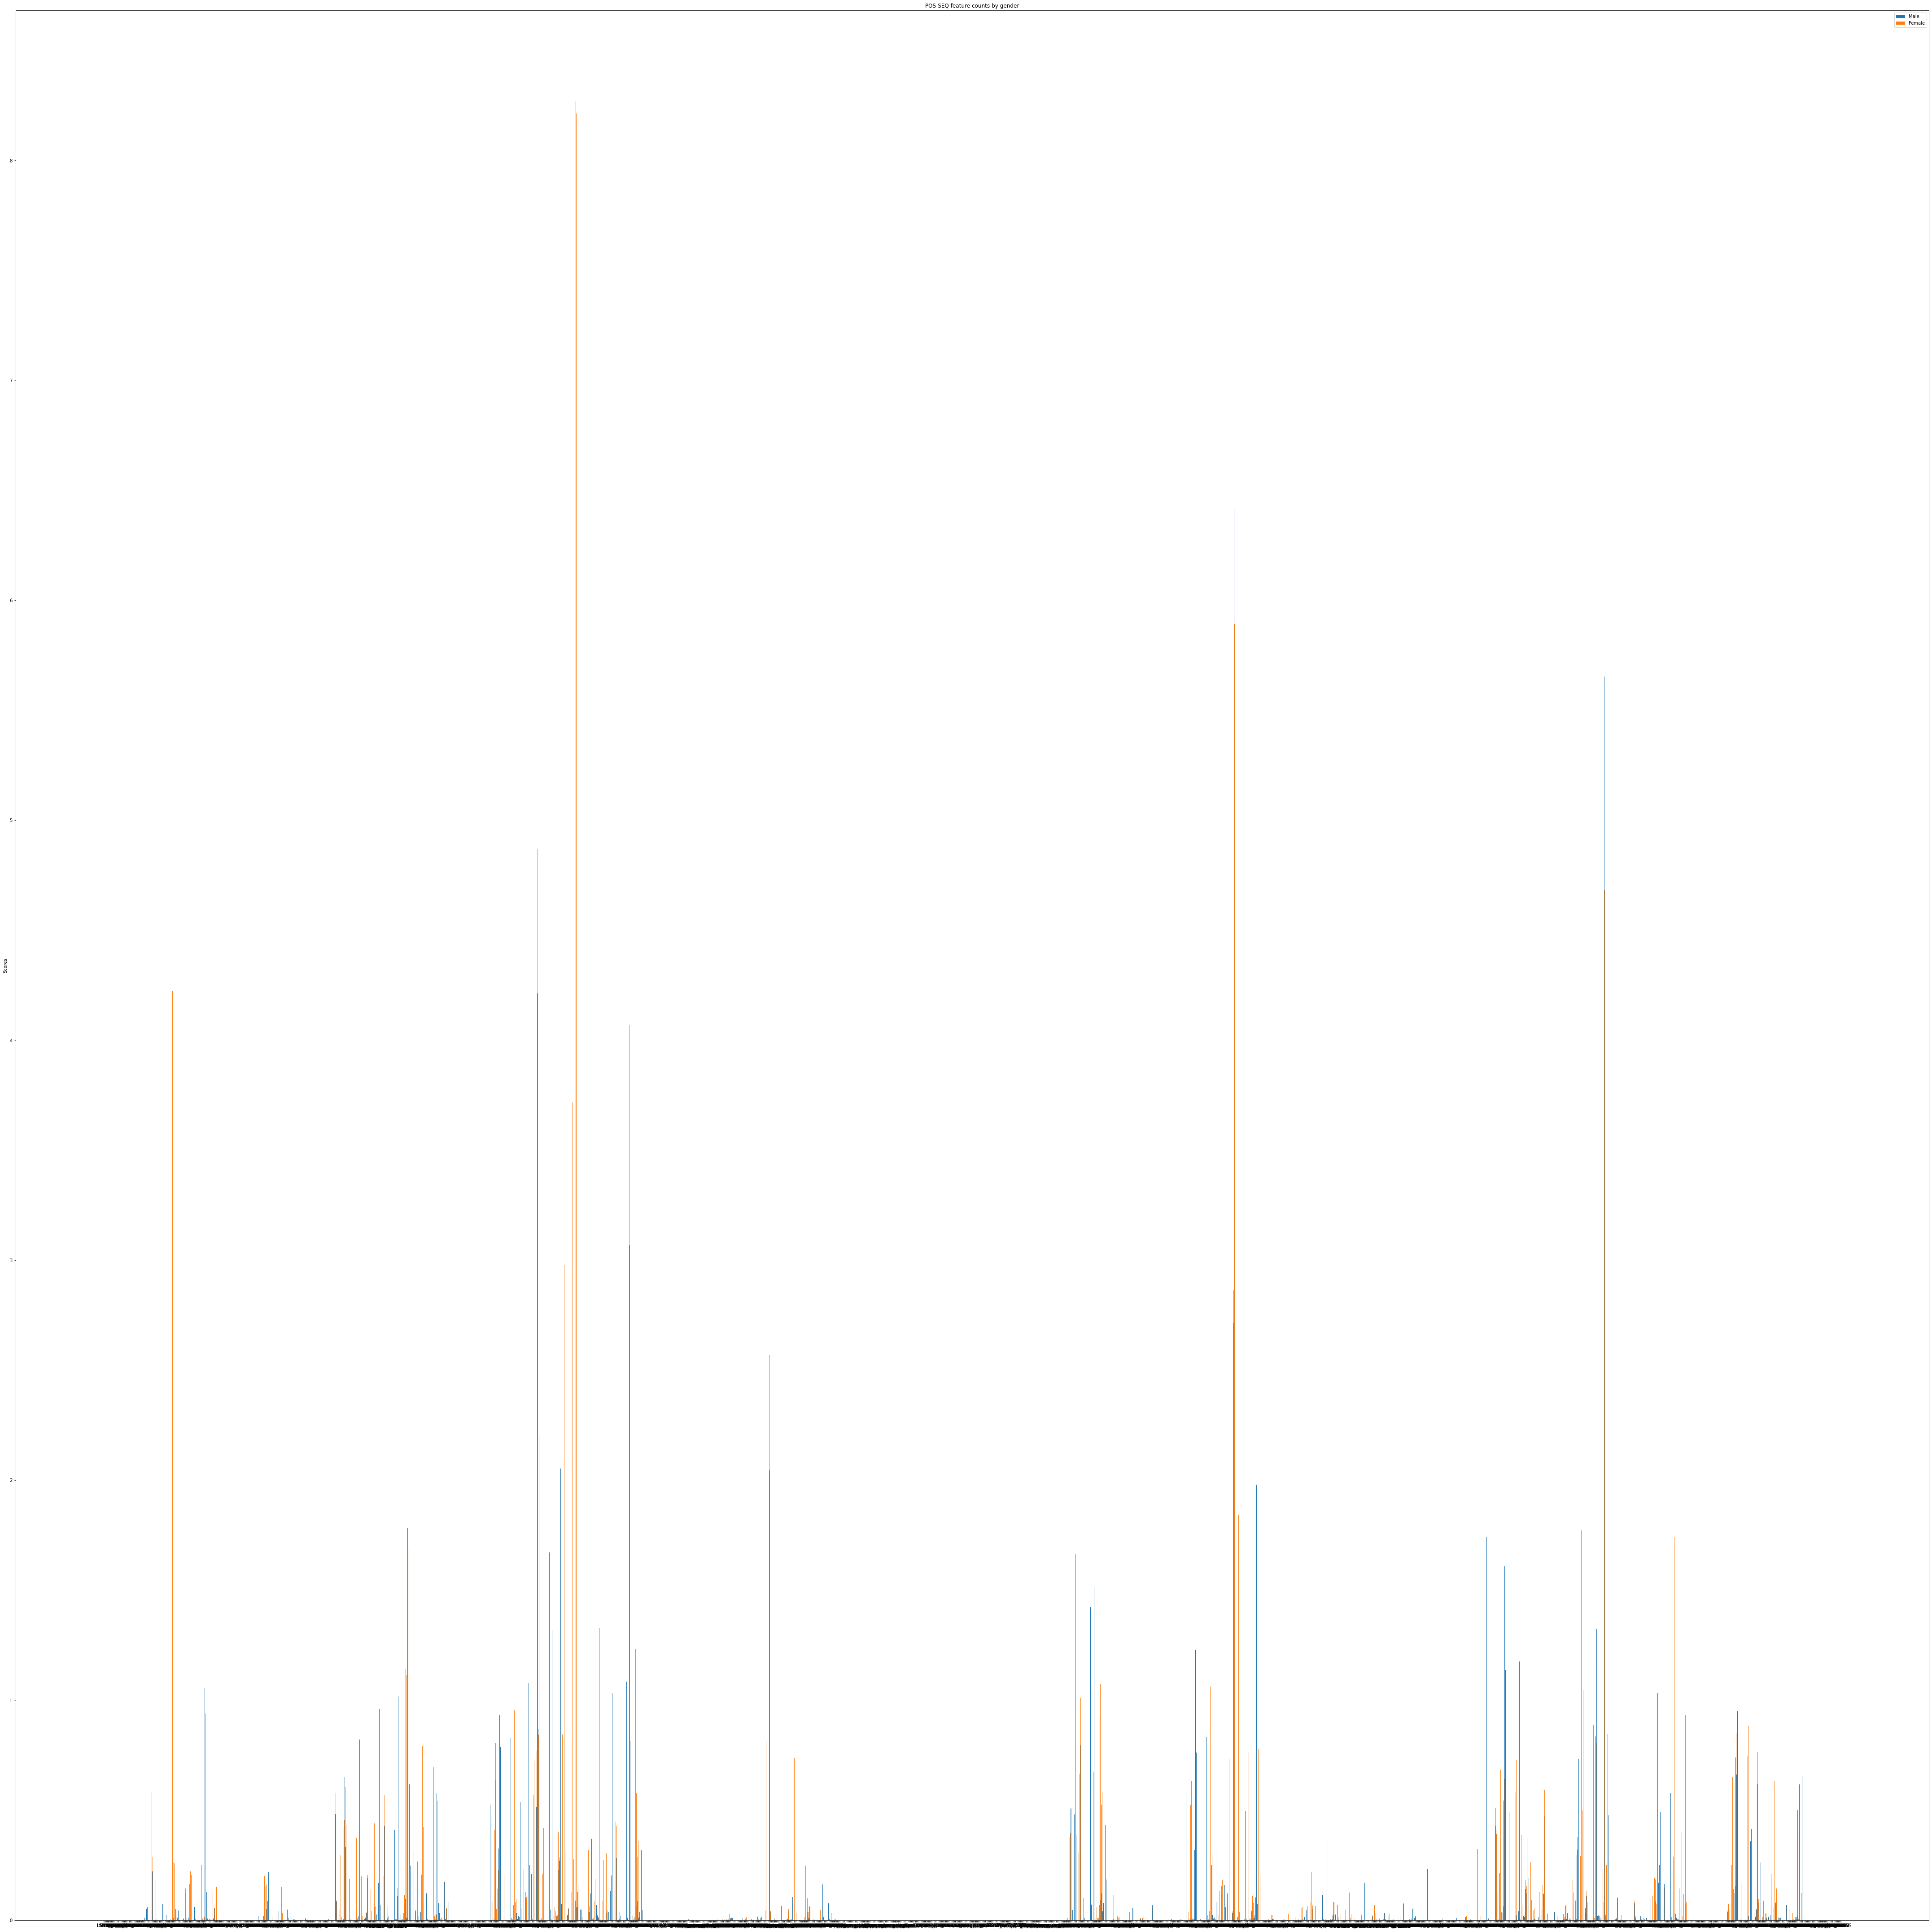

In [0]:
###-------POS-SEQ FEATURES VISUALIZATION (Bigram)----------
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

labels = []
length = len(tagseq)
male_means = np.zeros(length)
female_means = np.zeros(length)

for label in tagseq:
  split_label = label.split()
  new_label = split_label[0]+'-'+split_label[1]
  labels.append(new_label)

male_count = 0
female_count = 0
for idx in range(len(essays)):
  if gender_label[idx] == 0: #male
    male_means += np.asarray(pos_seq_features[idx])
    male_count += 1
  else:
    female_means += np.asarray(pos_seq_features[idx])
    female_count += 1

male_means = male_means/male_count
female_means = female_means/female_count

male_means = list(male_means)
female_means = list(female_means)

create_plot(labels, male_means, female_means, 'POS-SEQ feature counts by gender',0, 60, 1)


In [0]:
###------SVM WITH POS_SEQ_FEATURES-------
import sklearn
from sklearn import svm
from sklearn.metrics import accuracy_score
classifier = svm.SVC(kernel='rbf')
length = len(pos_features)
trainlength = round(0.8*length)
features = pos_seq_features
Xtrain = np.asarray(features[:trainlength])
Ytrain = np.asarray(gender_label[:trainlength])

#Xtrain = Xtrain.reshape(-1, 1)

classifier.fit(Xtrain, Ytrain)
Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

pred = classifier.predict(Xtest)
print(accuracy_score(Ytest, pred))

0.5975


In [0]:
###-----KNN WITH POS_SEQ FEATURES---------
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors

length = len(essays)
trainlength = round(0.8*length)
features = pos_seq_features
Xtrain = np.asarray(features[:trainlength])
Ytrain = np.asarray(gender_label[:trainlength])

clf = neighbors.KNeighborsClassifier(75)
clf.fit(Xtrain, Ytrain)

Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

pred = clf.predict(Xtest)
print(accuracy_score(Ytest, pred))

**Using n-gram (char) features:**

In [0]:
###-------CREATING NGRAM FEATURES-----------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def ngram_train_char(data, num, count_vect):
  if count_vect == []:
    count_vect = CountVectorizer(stop_words='english', analyzer='char', ngram_range=(num, num))
  ngram_counts = count_vect.fit_transform(data)
  return ngram_counts, count_vect

def ngram_test_char(data, model):
  ngram_counts = model.transform(data)
  return ngram_counts

In [0]:
###---------ORIGINAL NGRAMS WITH NAIVE BAYES------------
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nb_classifier = MultinomialNB()
batches = []
i = 0
while i < 250000:
  batches.append(i)
  i += 5000

print(batches)
acc = 0
for i in batches:
  essays, gender_label, age_label, original_data = prepare_data(i, 5000)
  del essays, age_label
  #print('prepared data')
  trainlength = round(0.8*len(gender_label))
  features = original_data

  Xtrain = np.asarray(features[0:trainlength])
  Ytrain = np.asarray(gender_label[0:trainlength])
  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(gender_label[trainlength:])
  del original_data, gender_label
  #print('train,test')

  if i == 0:
    train_data, model = ngram_train_char(Xtrain, 1, []) 
  else:
    train_data, model = ngram_train_char(Xtrain, 1, model) 

  test_data = ngram_test_char(Xtest, model)
  del Xtrain, Xtest
  #print('ngrams')

  nb_classifier.fit(train_data, Ytrain)
  pred = nb_classifier.predict(test_data)
  #print('predicted')

  del train_data, test_data,
  acc += accuracy_score(Ytest, pred)
  print('Batch', batches.index(i), ':', accuracy_score(Ytest, pred))
  del Ytrain, Ytest, pred
print('Overall accuracy:', acc/len(batches))

filename = 'ngram_char_model.sav'
pickle.dump(nb_classifier, open(filename, 'wb'))


[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000]
Batch 0 : 0.582
Batch 1 : 0.561
Batch 2 : 0.579
Batch 3 : 0.567
Batch 4 : 0.551
Batch 5 : 0.605
Batch 6 : 0.58
Batch 7 : 0.603
Batch 8 : 0.54
Batch 9 : 0.585
Batch 10 : 0.587
Batch 11 : 0.586
Batch 12 : 0.553
Batch 13 : 0.561
Batch 14 : 0.588
Batch 15 : 0.593
Batch 16 : 0.599
Batch 17 : 0.575
Batch 18 : 0.567
Batch 19 : 0.551
Batch 20 : 0.568
Batch 21 : 0.561
Batch 22 : 0.527
Batch 23 : 0.582
Batch 24 : 0.604
Batch 25 : 0.569
Batch 26 : 0.51
Batch 27 : 0.608
Batch 28 : 0.576
Batch 29 : 0.541
Batch 30 : 0.581
Batch 31 : 0.526
Batch 32 : 0.575
Batch 33 : 0.59
Batch 34 : 0.54
Batch 35 : 0.595
Batch 36 : 0.553
Batch 37 :

**Using n-gram (word) features:**

In [0]:
###-------CREATING NGRAM FEATURES-----------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def ngram_train(data, num, count_vect):
  if count_vect == []:
    count_vect = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(num, num))
  ngram_counts = count_vect.fit_transform(data)
  return ngram_counts, count_vect

def ngram_test(data, model):
  ngram_counts = model.transform(data)
  return ngram_counts

#tfidf_transformer = TfidfTransformer()
#tfidf_features = tfidf_transformer.fit_transform(original_data)
#tfidf_features.shape

In [0]:
###---------ORIGINAL NGRAMS WITH NAIVE BAYES------------
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
nb_classifier = MultinomialNB()

batches = []
i = 0
while i < 250000:
  batches.append(i)
  i += 5000

acc = 0
for i in batches:
  essays, gender_label, age_label, original_data = prepare_data(i, 5000)
  trainlength = round(0.8*len(gender_label))
  features = original_data

  Xtrain = np.asarray(features[0:trainlength])
  Ytrain = np.asarray(gender_label[0:trainlength])
  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(gender_label[trainlength:])

  if i == 0:
    train_data, model = ngram_train(Xtrain, 1, []) 
  else:
    train_data, model = ngram_train(Xtrain, 1, model) 

  test_data = ngram_test(Xtest, model)

  nb_classifier.fit(train_data, Ytrain)
  pred = nb_classifier.predict(test_data)
  acc += accuracy_score(Ytest, pred)
  print('Batch', batches.index(i), ':', accuracy_score(Ytest, pred))
print('Overall accuracy:', acc/len(batches))

filename = 'ngram_classifier_model.sav'
pickle.dump(nb_classifier, open(filename, 'wb'))

filename = 'ngram_model.sav'
pickle.dump(model, open(filename, 'wb'))


Batch 0 : 0.607
Batch 1 : 0.629
Batch 2 : 0.612
Batch 3 : 0.616
Batch 4 : 0.615
Batch 5 : 0.602
Batch 6 : 0.626
Batch 7 : 0.633
Batch 8 : 0.655
Batch 9 : 0.649
Batch 10 : 0.597
Batch 11 : 0.613
Batch 12 : 0.591
Batch 13 : 0.599
Batch 14 : 0.632
Batch 15 : 0.626
Batch 16 : 0.665
Batch 17 : 0.632
Batch 18 : 0.619
Batch 19 : 0.584
Batch 20 : 0.607
Batch 21 : 0.618
Batch 22 : 0.64
Batch 23 : 0.634
Batch 24 : 0.648
Batch 25 : 0.627
Batch 26 : 0.57
Batch 27 : 0.638
Batch 28 : 0.613
Batch 29 : 0.616
Batch 30 : 0.627
Batch 31 : 0.615
Batch 32 : 0.612
Batch 33 : 0.608
Batch 34 : 0.614
Batch 35 : 0.639
Batch 36 : 0.631
Batch 37 : 0.626
Batch 38 : 0.635
Batch 39 : 0.625
Batch 40 : 0.632
Batch 41 : 0.596
Batch 42 : 0.621
Batch 43 : 0.646
Batch 44 : 0.636
Batch 45 : 0.595
Batch 46 : 0.627
Batch 47 : 0.612
Batch 48 : 0.6
Batch 49 : 0.624
Overall accuracy: 0.6206799999999998


In [0]:
###------SVM WITH NGRAMS----------
from sklearn import svm
from sklearn.metrics import accuracy_score

classifier = svm.SVC(kernel='rbf')

batches = []
i = 0
while i < 250000:
  batches.append(i)
  i += 5000

acc = 0
for i in batches:
  essays, gender_label, age_label, original_data = prepare_data(i, 5000)
  trainlength = round(0.8*len(essays))
  features = original_data

  Xtrain = np.asarray(features[0:trainlength])
  Ytrain = np.asarray(gender_label[0:trainlength])
  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(gender_label[trainlength:])

  if i == 0:
    train_data, model = ngram_train(Xtrain, 1, [])
  else:
    train_data, model = ngram_train(Xtrain, 1, model) 
 
  test_data = ngram_test(Xtest, model)

  classifier.fit(train_data, Ytrain)
  pred = classifier.predict(test_data)
  acc += accuracy_score(Ytest, pred)
  print('Batch', batches.index(i), ':', accuracy_score(Ytest, pred))
print('Overall accuracy:', acc/len(batches))

Batch 0 : 0.555
Batch 1 : 0.583
Batch 2 : 0.615
Batch 3 : 0.588
Batch 4 : 0.591
Batch 5 : 0.571
Batch 6 : 0.582
Batch 7 : 0.591
Batch 8 : 0.575
Batch 9 : 0.605
Batch 10 : 0.598
Batch 11 : 0.585
Batch 12 : 0.582
Batch 13 : 0.578
Batch 14 : 0.609
Batch 15 : 0.593
Batch 16 : 0.602
Batch 17 : 0.596
Batch 18 : 0.586
Batch 19 : 0.575
Batch 20 : 0.577
Batch 21 : 0.612
Batch 22 : 0.592
Batch 23 : 0.57
Batch 24 : 0.564
Batch 25 : 0.57
Batch 26 : 0.567
Batch 27 : 0.588
Batch 28 : 0.559
Batch 29 : 0.617
Batch 30 : 0.592
Batch 31 : 0.551
Batch 32 : 0.587
Batch 33 : 0.581
Batch 34 : 0.579
Batch 35 : 0.605
Batch 36 : 0.583
Batch 37 : 0.628
Batch 38 : 0.614
Batch 39 : 0.611
Batch 40 : 0.584
Batch 41 : 0.586
Batch 42 : 0.587
Batch 43 : 0.579
Batch 44 : 0.559
Batch 45 : 0.563
Batch 46 : 0.581
Batch 47 : 0.555
Batch 48 : 0.592
Batch 49 : 0.61
Overall accuracy: 0.5860599999999999


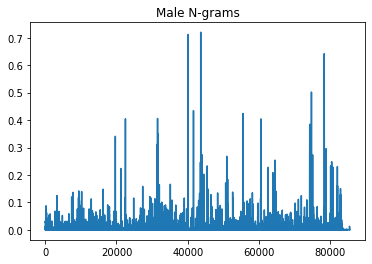

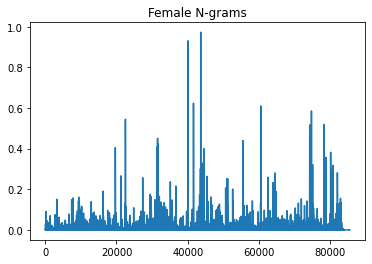

In [0]:
###-------NGRAM FEATURES VISUALIZATION ----------
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy

labels = []
mat_shape = train_data[0].shape
male_means =  scipy.sparse.csr_matrix(mat_shape)
female_means =  scipy.sparse.csr_matrix(mat_shape)

male_count = 0
female_count = 0
for idx in range(round(len(essays)*0.8)):
  if gender_label[idx] == 0: #male
    male_means = (male_means.tocsr() + train_data[idx].tocsr())
    male_count += 1
  else:
    female_means = (female_means.tocsr() + train_data[idx].tocsr())
    female_count += 1

male_means = male_means/male_count
female_means = female_means/female_count

#male_means = list(male_means)
#female_means = list(female_means)
male_m = scipy.sparse.csr_matrix.toarray(male_means)
plt.plot(male_m[0])
plt.title('Male N-grams')
plt.show()

female_m = scipy.sparse.csr_matrix.toarray(female_means)
plt.plot(female_m[0])
plt.title('Female N-grams')
plt.show()
#create_plot(labels, male_means, female_means, 'POS-SEQ feature counts by gender',0, 60, 1)


**Using pos-ngrams: (does not give good results)**

In [0]:
###----CREATING POS NGRAMS--------------
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
tagset = nltk.load('help/tagsets/upenn_tagset.pickle')
no_tags = len(tagset.keys())

def pos_cvt(data):
  pos_essays = []
  for post in data:
    pos = nltk.pos_tag(post)
    new_pos = [elem[1] for elem in pos]
    pos_essays.append(' '.join(new_pos))
  return pos_essays

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [0]:
###-------POS NGRAMS WITH NAIVE BAYES------------
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

trainlength = round(0.8*len(essays))
features = pos_cvt(original_data)

Xtrain = np.asarray(features[0:trainlength])
Ytrain = np.asarray(gender_label[0:trainlength])
Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

train_data, model = ngram_train(Xtrain) 
test_data = ngram_test(Xtest, model)
print(Xtrain.shape, Ytrain.shape,train_data.shape)

nb_classifier = MultinomialNB().fit(train_data, Ytrain)
pred = nb_classifier.predict(test_data)
print(accuracy_score(Ytest, pred))

In [0]:
###-------NGRAM FEATURES VISUALIZATION (Bigram)----------
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

labels = []
ff = model.get_feature_names()
length = len(ff)
male_means = np.zeros(length)
female_means = np.zeros(length)

for label in ff:
  labels.append(label)

male_count = 0
female_count = 0
for idx in range(len(Xtrain)):
  if gender_label[idx] == 0: #male
    male_means += np.asarray(train_data[idx])
    male_count += 1
  else:
    female_means += np.asarray(train_data[idx])
    female_count += 1

male_means = male_means/male_count
female_means = female_means/female_count

male_means = list(male_means)
female_means = list(female_means)

create_plot(labels, male_means, female_means, 'POS-SEQ feature counts by gender',0, 60, 0)

TypeError: ignored

**Using sentiment:**

In [0]:
###----CONVERT PENN TAGS TO WORDNET TAGS--------
def penn_to_wn(tag):
    if tag[1][0] == 'J':
        return wn.ADJ
    elif tag[1][0] =='N':
        return wn.NOUN
    elif tag[1][0] == 'R':
        return wn.ADV
    elif tag[1][0] == 'V':
        return wn.VERB
    return None

In [0]:
###------SENTIMENTS--------------
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
tagset = nltk.load('help/tagsets/upenn_tagset.pickle')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

lemmatizer = WordNetLemmatizer()

def sentiment_features(essays):
  f_pos_score = 0
  f_neg_score = 0
  f_obj_score = 0
  f_count = 0

  m_pos_score = 0
  m_neg_score = 0
  m_obj_score = 0
  m_count = 0

  mc = 0
  fc = 0

  total_feat = []
  for post_id in range(len(essays)):
    post = essays[post_id]
  #g = gender_label[post_id]

    pos = nltk.pos_tag(post)
    feat = np.zeros(3)

    for idx in range(len(pos)):
      tag = pos[idx]
      word = post[idx]
      wn_tag = penn_to_wn(tag)
      if wn_tag == None:
        continue
      lemma = lemmatizer.lemmatize(word, pos=wn_tag)
      if lemma == []:
        continue
      synsets = wn.synsets(word, pos=wn_tag)
      if synsets == []:
        continue

      synset = synsets[0] #most common
      swn_synset = swn.senti_synset(synset.name())
      pos_score = swn_synset.pos_score()
      neg_score = swn_synset.neg_score()
      obj_score = swn_synset.obj_score()
      feat[0] += pos_score
      feat[1] += neg_score
      feat[2] += obj_score
    total_feat.append(feat)
  return total_feat

    #if g == 0: #male
    #  m_pos_score += np.log10(pos_score+1)
    #  m_neg_score += np.log10(neg_score+1)
    #  m_obj_score += np.log10(obj_score+1)
    #  m_count += 1
    #  mc += 1
    #elif g == 1: #female
    #  f_pos_score += np.log10(pos_score+1)
    #  f_neg_score += np.log10(neg_score+1)
    #  f_obj_score += np.log10(obj_score+1)
    #  f_count += 1
    #  fc += 1
#m_pos = m_pos_score/m_count
#m_neg = m_neg_score/m_count
#m_obj = m_obj_score/m_count

#f_pos = f_pos_score/f_count
#f_neg = f_neg_score/f_count
#f_obj = f_obj_score/f_count

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


In [0]:
###------SVM WITH SENTIMENT FEATURES-------
import sklearn
from sklearn import svm
from sklearn.metrics import accuracy_score

#rbf: 54, linear:53.525, poly:52.15
classifier = svm.SVC(kernel='poly')
batches = []
i = 0
while i<250000:
  batches.append(i)
  i+=20000
acc = 0
for i in batches:
  essays, gender_label, age_label, original_data = prepare_data(i,20000)
  total_feat = sentiment_features(essays)
  length = len(total_feat)
  trainlength = round(0.8*length)
  features = total_feat
  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(gender_label[:trainlength])

#Xtrain = Xtrain.reshape(-1, 1)

  classifier.fit(Xtrain, Ytrain)
  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

  pred = classifier.predict(Xtest)
  acc += accuracy_score(Ytest, pred)
  print('Batch', batches.index(i), ':', accuracy_score(Ytest, pred))
print('Overall accuracy:', acc/len(batches))

Batch 0 : 0.5215
Batch 1 : 0.4955
Batch 2 : 0.5145
Batch 3 : 0.50975
Batch 4 : 0.50875
Batch 5 : 0.51975
Batch 6 : 0.5195
Batch 7 : 0.49825
Batch 8 : 0.50625
Batch 9 : 0.51675
Batch 10 : 0.50225
Batch 11 : 0.505
Batch 12 : 0.50925
Overall accuracy: 0.5097692307692306


In [0]:
###-----KNN WITH SENTIMENT FEATURES---------
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors

length = len(total_feat)
trainlength = round(0.8*length)
features = total_feat
Xtrain = np.asarray(features[:trainlength])
Ytrain = np.asarray(gender_label[:trainlength])

clf = neighbors.KNeighborsClassifier(75)
clf.fit(Xtrain, Ytrain)

Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(gender_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

pred = clf.predict(Xtest)
print(accuracy_score(Ytest, pred))

0.52125


# **Analysis on HP dataset:**

In [0]:
#Parth's code
def split_in_sets(data):
    essay_sets = []
    min_scores = []
    max_scores = []
    for s in range(1,9):
        essay_set = data[data["essay_set"] == s]
        essay_set.dropna(axis=1, inplace=True)
        n, d = essay_set.shape
        set_scores = essay_set["domain1_score"]
        print ("Set", s, ": Essays = ", n , "\t Attributes = ", d)
        min_scores.append(set_scores.min())
        max_scores.append(set_scores.max())
        essay_sets.append(essay_set)
    return (essay_sets, min_scores, max_scores)

In [0]:
#Parth's code
%matplotlib inline

dataset_path = "training_set_rel3.tsv"

import os
import pandas as pd

data = pd.read_csv(dataset_path, sep="\t", encoding="ISO-8859-1", index_col="essay_id")
min_scores = [2, 1, 0, 0, 0, 0, 0, 0]
max_scores = [12, 6, 3, 3, 4, 4, 30, 60]

essay_sets, data_min_scores, data_max_scores = split_in_sets(data)
set1, set2, set3, set4, set5, set6, set7, set8 = tuple(essay_sets)
data.dropna(axis=1, inplace=True)

data.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
print("All Data:", len(data))
data.head()

Set 1 : Essays =  1783 	 Attributes =  5
Set 2 : Essays =  1800 	 Attributes =  8
Set 3 : Essays =  1726 	 Attributes =  5
Set 4 : Essays =  1770 	 Attributes =  5
Set 5 : Essays =  1805 	 Attributes =  5
Set 6 : Essays =  1800 	 Attributes =  5
Set 7 : Essays =  1569 	 Attributes =  13
Set 8 : Essays =  723 	 Attributes =  17
All Data: 12976


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,essay_set,essay,domain1_score
essay_id,,,
1,1,"Dear local newspaper, I think effects computer...",8
2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
5,1,"Dear @LOCATION1, I know having computers has a...",8


In [0]:
#Parth's code
print("Minimum Scores: ", min_scores)
print("Maximum Scores: ", max_scores)

Minimum Scores:  [2, 1, 0, 0, 0, 0, 0, 0]
Maximum Scores:  [12, 6, 3, 3, 4, 4, 30, 60]


In [0]:
#Parth's code
#Dataset keys
essay_id_key = "essay_id"
essay_set_key = "essay_set"
essay_key = "essay"
domain1_score_key = "domain1_score"

In [0]:
e1, e2, e3, e4, e5, e6, e7, e8 = [], [], [], [], [], [], [], []
s1, s2, s3, s4, s5, s6, s7, s8 = [], [], [], [], [], [], [], []

for idx in range(len(set1)):
  e1.append(set1.iloc[idx][essay_key])
  s1.append(set1.iloc[idx][domain1_score_key])

for idx in range(len(set2)):
  e2.append(set2.iloc[idx][essay_key])
  s2.append(set2.iloc[idx][domain1_score_key])

for idx in range(len(set3)):
  e3.append(set3.iloc[idx][essay_key])
  s3.append(set3.iloc[idx][domain1_score_key])

for idx in range(len(set4)):
  e4.append(set4.iloc[idx][essay_key])
  s4.append(set4.iloc[idx][domain1_score_key])

for idx in range(len(set5)):
  e5.append(set5.iloc[idx][essay_key])
  s5.append(set5.iloc[idx][domain1_score_key])

for idx in range(len(set6)):
  e6.append(set6.iloc[idx][essay_key])
  s6.append(set6.iloc[idx][domain1_score_key])

for idx in range(len(set7)):
  e7.append(set7.iloc[idx][essay_key])
  s7.append(set7.iloc[idx][domain1_score_key])

for idx in range(len(set8)):
  e8.append(set8.iloc[idx][essay_key])
  s8.append(set8.iloc[idx][domain1_score_key])

filename1 = 'ngram_model.sav'
loaded_model1 = pickle.load(open(filename1, 'rb'))
filename2 = 'ngram_classifier_model.sav'
loaded_model2 = pickle.load(open(filename2, 'rb'))

e1 = np.asarray(e1)
e2 = np.asarray(e2)
e3 = np.asarray(e3)
e4 = np.asarray(e4)
e5 = np.asarray(e5)
e6 = np.asarray(e6)
e7 = np.asarray(e7)
e8 = np.asarray(e8)

s1 = np.asarray(s1)
s2 = np.asarray(s2)
s3 = np.asarray(s3)
s4 = np.asarray(s4)
s5 = np.asarray(s5)
s6 = np.asarray(s6)
s7 = np.asarray(s7)
s8 = np.asarray(s8)

for i in range(8):
  if i == 0:
    all_essays = e1
    all_scores = s1
  elif i == 1:
    all_essays = e2
    all_scores = s2

  elif i == 2:
    all_essays = e3
    all_scores = s3

  elif i == 3:
    all_essays = e4
    all_scores = s4

  elif i == 4:
    all_essays = e5
    all_scores = s5

  elif i == 5:
    all_essays = e6
    all_scores = s6

  elif i == 6:
    all_essays = e7
    all_scores = s7

  else:
    all_essays = e8
    all_scores = s8

  #essay_data = prepare_test(all_essays)
  #print(type(all_essays), type(essay_data))
  test_data = ngram_test(all_essays, loaded_model1)

  pred = loaded_model2.predict(test_data)

  f_pred_scores = 0
  m_pred_scores = 0
  f_count = 0
  m_count = 0

  for idx in range(len(all_essays)):
    if pred[idx] == 0: #male
      m_count += 1
      m_pred_scores += all_scores[idx]
    else:
      f_count += 1
      f_pred_scores += all_scores[idx]
  
  avg_male = m_pred_scores/m_count
  avg_female = f_pred_scores/f_count
  print('Avg male score for set', i+1, ':', avg_male)
  print('Avg female score for set:', i+1, ':',avg_female)
  print('Number of males for set', i+1, ':',m_count)
  print('Number of females for set', i+1, ':',f_count)
  print('\n')

Avg male score for set 1 : 8.663244353182751
Avg female score for set: 1 : 7.916149068322981
Number of males for set 1 : 1461
Number of females for set 1 : 322


Avg male score for set 2 : 3.5734557595993324
Avg female score for set: 2 : 3.101328903654485
Number of males for set 2 : 1198
Number of females for set 2 : 602


Avg male score for set 3 : 1.878188775510204
Avg female score for set: 3 : 1.5506329113924051
Number of males for set 3 : 1568
Number of females for set 3 : 158


Avg male score for set 4 : 1.6603773584905661
Avg female score for set: 4 : 1.3480278422273781
Number of males for set 4 : 477
Number of females for set 4 : 1293


Avg male score for set 5 : 2.603448275862069
Avg female score for set: 5 : 2.3415361670395227
Number of males for set 5 : 464
Number of females for set 5 : 1341


Avg male score for set 6 : 2.728595411303861
Avg female score for set: 6 : 1.5384615384615385
Number of males for set 6 : 1787
Number of females for set 6 : 13


Avg male score for set 

In [0]:
all_essays = []
all_scores = []
norm_score = []

for idx in range(len(data)):
  all_essays.append(data.iloc[idx][essay_key])
  all_scores.append(data.iloc[idx][domain1_score_key])
  set_id = data.iloc[idx][essay_set_key]

  sc = data.iloc[idx][domain1_score_key]
  if set_id == 1:
    norm_score.append(sc/12)
  elif set_id == 2:
    norm_score.append(sc/6)
  elif set_id == 3 or set_id == 4:
    norm_score.append(sc/3)
  elif set_id == 5 or set_id == 6:
    norm_score.append(sc/4)
  elif set_id == 7:
    norm_score.append(sc/30)
  else:
    norm_score.append(sc/60)

filename1 = 'ngram_model.sav'
loaded_model1 = pickle.load(open(filename1, 'rb'))
filename2 = 'ngram_classifier_model.sav'
loaded_model2 = pickle.load(open(filename2, 'rb'))

all_essays = np.asarray(all_essays)
test_data = ngram_test(all_essays, loaded_model1)

pred = loaded_model2.predict(test_data)

f_pred_scores = 0
m_pred_scores = 0
f_count = 0
m_count = 0

for idx in range(len(data)):
  if pred[idx] == 0: #male
    m_count += 1
    m_pred_scores += norm_score[idx]
  else:
    f_count += 1
    f_pred_scores += norm_score[idx]
  
avg_male = m_pred_scores/m_count
avg_female = f_pred_scores/f_count
print('Avg male score:', avg_male)
print('Avg female score:', avg_female)
print('Number of males:', m_count)
print('Number of females:', f_count)

Avg male score: 0.6458762414755862
Avg female score: 0.5432226711165717
Number of males: 7283
Number of females: 5693


In [0]:
import operator

mdict = {}
mscore = {}
fscore = {}
fdict = {}
tdict = {}
tscore = {}

for idx in range(len(data)):
  writtenwhole = data.iloc[idx][essay_key]
  written = writtenwhole.split(' ')
  if pred[idx] == 0:
    for word in written:
      w = word.lower()
      if w in stop_words or w == ' ' or len(w) == 0:
        continue
      if w[0] == '@':
        continue
      if w not in mdict:
        mdict[w] = 1
        mscore[w] = norm_score[idx]
      else:
        mdict[w] += 1
        mscore[w] += norm_score[idx]
      if w not in tdict:
        tdict[w] = 1
        tscore[w] = norm_score[idx]
      else:
        tdict[w] += 1
        tscore[w] += norm_score[idx]
  else:
    for word in written:
      w = word.lower()
      #print('jel', w)
      if w in stop_words or w == ' ' or len(w) == 0:
        continue
      if w[0] == '@':
        continue
      if w not in fdict:
        fdict[w] = 1
        fscore[w] = norm_score[idx]
      else:
        fdict[w] += 1
        fscore[w] += norm_score[idx]

      if w not in tdict:
        tdict[w] = 1
        tscore[w] = norm_score[idx]
      else:
        tdict[w] += 1
        tscore[w] += norm_score[idx]
    
mm = dict(sorted(mdict.items(), key=operator.itemgetter(1), reverse=True)[:10])
ff = dict(sorted(fdict.items(), key=operator.itemgetter(1), reverse=True)[:10])
print('Males:', [w for w in mm.keys()])
print('Females:', [w for w in ff.keys()])

for idx in mdict:
  mscore[idx] = mscore[idx]/mdict[idx]
for idx in fdict:
  fscore[idx] = fscore[idx]/fdict[idx]
for idx in tdict:
  tscore[idx] = tscore[idx]/tdict[idx]

print('\n')
print('Top 10 scoring words:','   ','Avg no. of times used by males in an essay', '   ','Avg no. of times used by females in an essay')
s2 = dict(sorted(tdict.items(), key=operator.itemgetter(1), reverse=True)[:10])
#print(s2)
for w in s2:
  print(w, '                   ', mscore[w], '                      ', fscore[w])


Males: ['people', 'would', 'computers', 'computer', 'many', 'could', 'one', 'building', 'also', 'like']
Females: ['people', 'like', 'would', 'get', 'one', 'time', 'think', 'go', 'author', 'got']


Top 10 scoring words:     Avg no. of times used by males in an essay     Avg no. of times used by females in an essay
people                     0.6895147781920875                        0.6072997644287381
would                     0.7115344027015519                        0.6075053477908029
like                     0.6660970557774836                        0.5820515316718529
computers                     0.7467899332306276                        0.679380185456323
one                     0.6899979691307958                        0.6041606425702792
get                     0.679354504404471                        0.5929995569339739
could                     0.708059604794306                        0.6220195086705191
think                     0.64203528827038                        0.55618382621

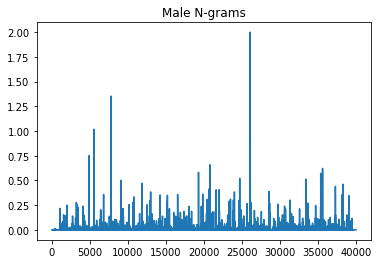

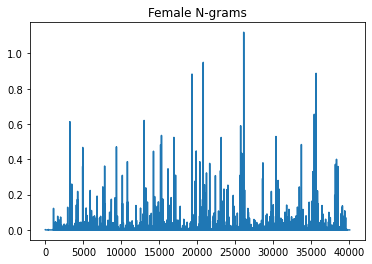

In [0]:
###-------NGRAM FEATURES VISUALIZATION ----------
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy

labels = []
mat_shape = test_data[0].shape
male_means =  scipy.sparse.csr_matrix(mat_shape)
female_means =  scipy.sparse.csr_matrix(mat_shape)

male_count = 0
female_count = 0
for idx in range(len(data)):
  if pred[idx] == 0: #male
    male_means = (male_means.tocsr() + test_data[idx].tocsr())
    male_count += 1
  else:
    female_means = (female_means.tocsr() + test_data[idx].tocsr())
    female_count += 1

male_means = male_means/male_count
female_means = female_means/female_count

#male_means = list(male_means)
#female_means = list(female_means)
male_m = scipy.sparse.csr_matrix.toarray(male_means)
plt.plot(male_m[0])
plt.title('Male N-grams')
plt.show()

female_m = scipy.sparse.csr_matrix.toarray(female_means)
plt.plot(female_m[0])
plt.title('Female N-grams')
plt.show()


# **Analysis on generalization dataset**

In [0]:
import csv
import os
import pandas as pd
import sys

new_data = pd.read_csv('blog-gender-dataset.csv', sep="\t", encoding="ISO-8859-1")

In [0]:
def search_for(biglist):
  y = []
  x = []
  string = ''
  for i in range(len(biglist)):
    if biglist[i] == 'M' or biglist[i] == 'm':
      x.append(string)
      y.append(0)
      string = ''
    elif biglist[i] == 'F' or biglist[i] == 'f':
      x.append(string)
      y.append(1)
      string = ''
    else:
      string = string+' '+biglist[i]
  return x,y

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
all_essays = []
gender = []

for idx in range(len(new_data)):
  s = new_data.iloc[idx]
  t = prepare_test(s)
  x,y = search_for(t[0])
  for j in range(len(x)): 
    all_essays.append(x[j])
    gender.append(y[j])

filename1 = 'ngram_model.sav'
loaded_model1 = pickle.load(open(filename1, 'rb'))
filename2 = 'ngram_classifier_model.sav'
loaded_model2 = pickle.load(open(filename2, 'rb'))

all_essays = np.asarray(all_essays)
test_data = ngram_test(all_essays, loaded_model1)

pred = loaded_model2.predict(test_data)
pred = np.asarray(pred)
gender = np.asarray(gender)
print('Accuracy score for generalization dataset:', accuracy_score(gender, pred))
print('Confusion matrix:')
print(confusion_matrix(gender, pred))

Accuracy score for generalization dataset: 0.6163180996643429
Confusion matrix:
[[1448  814]
 [ 672  939]]


# **Age Profiling**

In [0]:
def prepare_age(start, essays, age, original_data, age_label):
  data_length = 40000 #10000 

  for i in range(start, start+data_length):
    poster_age = int(data[i]['age'])
    post = data[i]['post']
    tokens = regexp_tokenize(post, default_pattern)

    if poster_age <= 12 or poster_age > 16: #13-16 inclusive
      continue
    essays.append(tokens)
    age.append(poster_age)
    original_data.append(post)
    if poster_age == 13 or poster_age == 14:
      age_label.append(1)
    elif poster_age == 15 or poster_age == 16:
      age_label.append(2)

  return essays, age, original_data, age_label

In [0]:
def prepare_test(essays):
  token_essays = []
  for i in range(len(essays)):
    post = essays[i]
    tokens = regexp_tokenize(post, default_pattern)
    token_essays.append(tokens)
  return token_essays

In [0]:
essays = []
age = []
original_data = []
age_label = []

essays, age, original_data, age_label = prepare_age(0, essays, age, original_data, age_label)
essays, age, original_data, age_label = prepare_age(40000, essays, age, original_data, age_label)
essays, age, original_data, age_label = prepare_age(80000, essays, age, original_data, age_label)
essays, age, original_data, age_label = prepare_age(120000, essays, age, original_data, age_label)
essays, age, original_data, age_label = prepare_age(160000, essays, age, original_data, age_label)
essays, age, original_data, age_label = prepare_age(200000, essays, age, original_data, age_label)
essays, age, original_data, age_label = prepare_age(240000, essays, age, original_data, age_label)
essays, age, original_data, age_label = prepare_age(280000, essays, age, original_data, age_label)
essays, age, original_data, age_label = prepare_age(320000, essays, age, original_data, age_label)

**Age statistics:**

In [0]:
c13 = 0
c14 = 0
c15 = 0
c16 = 0
c11 = 0
c12 = 0

c0 = 0
c1 = 0
c2 = 0
c3 = 0
for i in range(len(age)):
  if age[i] == 13:
    c13 += 1
  elif age[i] == 14:
    c14 += 1
  elif age[i] == 15:
    c15 += 1
  elif age[i] == 16:
    c16 += 1
    
  if age_label[i] == 1:
    c1 += 1
  elif age_label[i] == 2:
    c2 += 1

print('Number of entries', len(age))

print('13', c13, 'Percent of data', c13/len(age))
print('14', c14, 'Percent of data', c14/len(age))
print('15', c15, 'Percent of data', c15/len(age))
print('16', c16, 'Percent of data', c16/len(age))
print('\n')

print('13-14', c1, 'Percent of data', c1/len(age_label))
print('15-16', c2, 'Percent of data', c2/len(age_label))


Number of entries 79997
13 7211 Percent of data 0.09014088028301061
14 14496 Percent of data 0.18120679525482206
15 21220 Percent of data 0.2652599472480218
16 37070 Percent of data 0.46339237721414556


13-14 21707 Percent of data 0.2713476755378327
15-16 58290 Percent of data 0.7286523244621673


**Using POS features:**

In [0]:
###------SVM WITH POS_FEATURES-------
from sklearn.multiclass import OneVsRestClassifier
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

classifier = OneVsRestClassifier(SVC(class_weight={0: 2, 1:1}))
batches = [0,40000,80000,120000,160000,200000,240000,280000,320000]
acc = 0
for i in batches:
  essays, age, original_data, age_label = prepare_age(i, [], [], [], [])

  pos_features = POS(essays)
  length = len(essays)
  trainlength = round(0.8*length)
  features = pos_features
  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(age_label[:trainlength])

  classifier.fit(Xtrain, Ytrain)
#Xtrain = Xtrain.reshape(-1, 1)

  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(age_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

  pred = classifier.predict(Xtest)
  acc += accuracy_score(Ytest, pred)

  print('Batch', batches.index(i), ':',accuracy_score(Ytest, pred))
print('Overall accuracy:', acc/len(batches))

Batch 0 : 0.7374517374517374
Batch 1 : 0.7269662921348314
Batch 2 : 0.7342419080068143
Batch 3 : 0.7471655328798186
Batch 4 : 0.7403409090909091
Batch 5 : 0.7379619260918253
Batch 6 : 0.7283398546674119
Batch 7 : 0.7323462414578588
Batch 8 : 0.7139664804469273
Overall accuracy: 0.733197875803126


In [0]:
###-----KNN WITH POS_FEATURES---------
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors

clf = neighbors.KNeighborsClassifier(75)

batches = [0,40000,80000,120000,160000,200000,240000,280000,320000]
acc = 0
for i in batches:
  essays, age, original_data, age_label = prepare_age(i, [], [], [], [])
  pos_features = POS(essays)
  length = len(pos_features)
  trainlength = round(0.8*length)
  features = pos_features
  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(age_label[:trainlength])

  clf.fit(Xtrain, Ytrain)

  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(age_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

  pred = clf.predict(Xtest)
  acc += accuracy_score(Ytest, pred)
  print('Batch', batches.index(i), ':', accuracy_score(Ytest, pred))
print('Overall accuracy:', acc/len(batches))

Batch 0 : 0.7402095973524545
Batch 1 : 0.7331460674157303
Batch 2 : 0.7421919363997729
Batch 3 : 0.7477324263038548
Batch 4 : 0.740909090909091
Batch 5 : 0.7474804031354984
Batch 6 : 0.7361654555617664
Batch 7 : 0.7329157175398633
Batch 8 : 0.7212290502793296
Overall accuracy: 0.7379977494330402


In [0]:
###-----LINEAR REGRESSION WITH POS_FEATURES---------
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import neighbors

clf = LinearRegression()

batches = [0,40000,80000,120000,160000,200000,240000,280000,320000]
mse = 0
acc = 0
for i in batches:
  essays, age, original_data, age_label = prepare_age(i, [], [], [], [])
  pos_features = POS(essays)
  length = len(pos_features)
  trainlength = round(0.8*length)
  features = pos_features
  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(age_label[:trainlength])

  clf.fit(Xtrain, Ytrain)

  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(age_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

  pred = clf.predict(Xtest)
  c_pred = np.round(pred)
  mse += mean_squared_error(Ytest, pred)
  acc += accuracy_score(Ytest, c_pred)
  print('Batch', batches.index(i), ':', mean_squared_error(Ytest, pred), 'accuracy:', accuracy_score(Ytest, c_pred))
print('Overall mean squared error:', mse/len(batches))
print('Overall accuracy:', acc/len(batches))

Batch 0 : 0.19065496646321303 accuracy: 0.7402095973524545
Batch 1 : 0.19725587550564172 accuracy: 0.7292134831460674
Batch 2 : 0.18986803600452878 accuracy: 0.7427597955706985
Batch 3 : 0.1866866518154498 accuracy: 0.7477324263038548
Batch 4 : 0.19271158193736018 accuracy: 0.7397727272727272
Batch 5 : 0.18899030530527478 accuracy: 0.7458006718924972
Batch 6 : 0.19623009295556926 accuracy: 0.7350475125768586
Batch 7 : 0.19623277399256908 accuracy: 0.7323462414578588
Batch 8 : 0.20006606474384173 accuracy: 0.7195530726256983
Overall mean squared error: 0.19318848319149426
Overall accuracy: 0.7369372809109686


In [0]:
filename = 'age_regression_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [0]:
###---------RANDOM FOREST CLASSIFIER-----------
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=4, max_depth=5)

batches = [0,40000,80000,120000,160000,200000,240000,280000,320000]
acc = 0
for i in batches:
  essays, age, original_data, age_label = prepare_age(i, [], [], [], [])
  pos_features = POS(essays)
  length = len(pos_features)
  trainlength = round(0.8*length)
  features = pos_features
  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(age_label[:trainlength])

  clf.fit(Xtrain, Ytrain)

  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(age_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

  pred = clf.predict(Xtest)
  acc += accuracy_score(Ytest, pred)
  print('Batch', batches.index(i), ':', accuracy_score(Ytest, pred))
print('Overall accuracy:', acc/len(batches))

Batch 0 : 0.7380033094318809
Batch 1 : 0.7292134831460674
Batch 2 : 0.7444633730834753
Batch 3 : 0.7477324263038548
Batch 4 : 0.7403409090909091
Batch 5 : 0.7452407614781635
Batch 6 : 0.7305757406372275
Batch 7 : 0.7312072892938497
Batch 8 : 0.7212290502793296
Overall accuracy: 0.736445149193862


**Using n-grams**

In [0]:
###---------ORIGINAL NGRAMS WITH NAIVE BAYES------------
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
nb_classifier = MultinomialNB()

batches = []
for i in range(100):
  batches.append(i*1000)
acc = 0
for i in batches:
  essays, age, original_data, age_label = prepare_age(i, [], [], [], [])
  trainlength = round(0.8*len(essays))
  features = original_data

  Xtrain = np.asarray(features[0:trainlength])
  Ytrain = np.asarray(age_label[0:trainlength])
  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(age_label[trainlength:])

  train_data, model = ngram_train(Xtrain, 1) 
  test_data = ngram_test(Xtest, model)

  nb_classifier.fit(train_data, Ytrain)
  pred = nb_classifier.predict(test_data)

  acc += accuracy_score(Ytest, pred)
  print('Batch',batches.index(i),':',accuracy_score(Ytest, pred))
print('Overall accuracy:',acc/len(batches))

Batch 0 : 0.7578599007170436
Batch 1 : 0.7575757575757576
Batch 2 : 0.7588300220750552
Batch 3 : 0.7527593818984547
Batch 4 : 0.7615894039735099
Batch 5 : 0.7545706371191135
Batch 6 : 0.7512520868113522
Batch 7 : 0.7426183844011142
Batch 8 : 0.7399777282850779
Batch 9 : 0.7324805339265851
Batch 10 : 0.7259052924791086
Batch 11 : 0.7324022346368715
Batch 12 : 0.7292015633724176
Batch 13 : 0.7329988851727982
Batch 14 : 0.7384529771841959
Batch 15 : 0.7433333333333333
Batch 16 : 0.7357340720221607
Batch 17 : 0.745141588006663
Batch 18 : 0.7386237513873474
Batch 19 : 0.7465258476931629
Batch 20 : 0.7401443642420877
Batch 21 : 0.733222407099279
Batch 22 : 0.7258601553829079
Batch 23 : 0.7288888888888889
Batch 24 : 0.7332962138084632
Batch 25 : 0.7316258351893096
Batch 26 : 0.7423312883435583
Batch 27 : 0.7434613244296049
Batch 28 : 0.7484696716750139
Batch 29 : 0.7427616926503341
Batch 30 : 0.7497206703910615
Batch 31 : 0.7388392857142857
Batch 32 : 0.7371651785714286
Batch 33 : 0.737136465

In [0]:
###---------ORIGINAL NGRAMS (char) WITH NAIVE BAYES------------
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
nb_classifier = MultinomialNB()

batches = []
for i in range(100):
  batches.append(i*1000)
acc = 0
for i in batches:
  essays, age, original_data, age_label = prepare_age(i, [], [], [], [])
  trainlength = round(0.8*len(essays))
  features = original_data

  Xtrain = np.asarray(features[0:trainlength])
  Ytrain = np.asarray(age_label[0:trainlength])
  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(age_label[trainlength:])

  if i ==  0:
    train_data, model = ngram_train_char(Xtrain, 1, []) 
  else:
    train_data, model = ngram_train_char(Xtrain, 1, model) 

  test_data = ngram_test_char(Xtest, model)

  nb_classifier.fit(train_data, Ytrain)
  pred = nb_classifier.predict(test_data)

  acc += accuracy_score(Ytest, pred)
  print('Batch',batches.index(i),':',accuracy_score(Ytest, pred))
print('Overall accuracy:',acc/len(batches))

Batch 0 : 0.6249310535024821
Batch 1 : 0.6198347107438017
Batch 2 : 0.6214128035320088
Batch 3 : 0.6225165562913907
Batch 4 : 0.6280353200883002
Batch 5 : 0.628808864265928
Batch 6 : 0.6349471341124096
Batch 7 : 0.6417827298050139
Batch 8 : 0.6603563474387528
Batch 9 : 0.6579532814238043
Batch 10 : 0.6540389972144847
Batch 11 : 0.6558659217877095
Batch 12 : 0.6543830262423227
Batch 13 : 0.6739130434782609
Batch 14 : 0.6649972175848636
Batch 15 : 0.6616666666666666
Batch 16 : 0.6559556786703601
Batch 17 : 0.6546363131593559
Batch 18 : 0.6642619311875694
Batch 19 : 0.6659255141745414
Batch 20 : 0.6524153248195447
Batch 21 : 0.6444814198557959
Batch 22 : 0.6437291897891232
Batch 23 : 0.6416666666666667
Batch 24 : 0.6542316258351893
Batch 25 : 0.6531180400890868
Batch 26 : 0.6553262688232013
Batch 27 : 0.657762938230384
Batch 28 : 0.6583194212576516
Batch 29 : 0.6642538975501113
Batch 30 : 0.6581005586592179
Batch 31 : 0.6668526785714286
Batch 32 : 0.6635044642857143
Batch 33 : 0.664988814

**Using methods defined in: http://ceur-ws.org/Vol-1446/smlir_submission2.pdf**

In [0]:
!pip install pyphen
import pyphen
dic = pyphen.Pyphen(lang='en')

def extract_features(essays, age):
  features = []
  age_label = []
  for e in essays:
    n_words = len(e)

    if e == []:
      continue
    complex_words = 0
    syllables = 0
    n_chars = 0
    n1 = 0
    n2 = 0
    n3 = 0
    n4 = 0
    n5 = 0
    n6 = 0
    n7 = 0
    n8 = 0

    for word in e:
      syl = dic.inserted(word)
      syllables += syl.count('-') 
      sc = syl.count('-')
      if sc > 2:
        complex_words += 1
      if sc == 1:
        n1 += 1
      if sc == 2:
        n2 += 1
      if sc == 3:
        n3 += 1
      if sc == 4:
        n4 += 1
      if sc == 5:
        n5 += 1
      if sc == 6:
        n6 += 1
      if sc == 7:
        n7 += 1
      if sc == 8:
        n8 += 1
      n_chars += len(word)
    f = [n_chars/n_words, n_words, complex_words/n_words, syllables/n_words, n1/n_words, n2/n_words, n3/n_words, n4/n_words, n5/n_words, n6/n_words, n7/n_words, n8/n_words]
    features.append(f)
    age_label.append(age[essays.index(e)])
  return features, age_label

def pentel_features(essays):
  features = []
  age_label = []
  for e in essays:
    n_words = len(e)

    if e == []:
      continue
    complex_words = 0
    syllables = 0
    n_chars = 0
    n1 = 0
    n2 = 0
    n3 = 0
    n4 = 0
    n5 = 0
    n6 = 0
    n7 = 0
    n8 = 0

    for word in e:
      syl = dic.inserted(word)
      syllables += syl.count('-') 
      sc = syl.count('-')
      if sc > 2:
        complex_words += 1
      if sc == 1:
        n1 += 1
      if sc == 2:
        n2 += 1
      if sc == 3:
        n3 += 1
      if sc == 4:
        n4 += 1
      if sc == 5:
        n5 += 1
      if sc == 6:
        n6 += 1
      if sc == 7:
        n7 += 1
      if sc == 8:
        n8 += 1
      n_chars += len(word)
    f = [n_chars/n_words, n_words, complex_words/n_words, syllables/n_words, n1/n_words, n2/n_words, n3/n_words, n4/n_words, n5/n_words, n6/n_words, n7/n_words, n8/n_words]
    features.append(f)
  return features

In [0]:
###------SVM WITH PENTEL FEATURES-------
from sklearn.multiclass import OneVsRestClassifier
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

classifier = OneVsRestClassifier(SVC())
batches = []
i = 0
while i < 320000:
  batches.append(i)
  i += 40000
acc = 0

for i in batches:
  essays, age, original_data, age_label = prepare_age(i, [], [], [], [])

  features, age_label = extract_features(essays, age_label)
  length = len(features)
  trainlength = round(0.8*length)
  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(age_label[:trainlength])

  classifier.fit(Xtrain, Ytrain)
#Xtrain = Xtrain.reshape(-1, 1)

  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(age_label[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

  pred = classifier.predict(Xtest)

  acc += accuracy_score(Ytest, pred)
  print('Batch', batches.index(i), ':',accuracy_score(Ytest, pred))
print('Overall accuracy:', acc/len(batches))

KeyError: ignored

In [0]:
filename = 'age_pentel_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

**Using f-features:**

In [0]:
###------SVM WITH F FEATURES-------
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
classifier = OneVsRestClassifier(SVC())

batches = []
acc = 0
for i in batches:
  essays, age, original_data = prepare_age(i, [], [], [])
  pos_features = POS(essays)
  f_feature = f(pos_features, tagdict)
  length = len(essays)
  trainlength = round(0.8*length)
  features = f_feature
  Xtrain = np.asarray(features[:trainlength])
  Ytrain = np.asarray(age[:trainlength])

  Xtrain = Xtrain.reshape(-1, 1)
  classifier.fit(Xtrain, Ytrain)

  Xtest = np.asarray(features[trainlength:])
  Ytest = np.asarray(age[trainlength:])

  Xtest = Xtest.reshape(-1, 1)

  pred = classifier.predict(Xtest)
  acc += accuracy_score(Ytest, pred)
  print('Batch', batches.index(i), ':', accuracy_score(Ytest, pred))
print('Overall accuracy:', acc/len(batches))

NameError: ignored

**Using possessives:**

In [0]:
###-----KNN WITH POSSESSIVES FEATURES---------
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from sklearn.metrics import accuracy_score

#6000:51, 10000:52.45
num = 10000
labels = age_label[:num]
data = essays[:num]

my_feature, other_feature, total_dict = possessives_features(data)

length = len(my_feature)
print(length)
trainlength = round(0.8*length)
features = my_feature
Xtrain = np.asarray(features[:trainlength])
Ytrain = np.asarray(labels[:trainlength])

clf = neighbors.KNeighborsClassifier(75)
clf.fit(Xtrain, Ytrain)

Xtest = np.asarray(features[trainlength:])
Ytest = np.asarray(labels[trainlength:])

#Xtest = Xtest.reshape(-1, 1)

pred = clf.predict(Xtest)
print(accuracy_score(Ytest, pred))

dict len is 5437 index 5437
10000
0.5405


In [0]:
import sklearn
from sklearn.metrics import accuracy_score

all_essays = []
all_scores = []
norm_score = []
y = []

classifier = pickle.load(open('age_pentel_model.sav', 'rb'))
c1 = 0
c2 = 0

for idx in range(len(data)):
  all_essays.append(data.iloc[idx][essay_key])
  all_scores.append(data.iloc[idx][domain1_score_key])
  set_id = data.iloc[idx][essay_set_key]
  if set_id == 7 or set_id == 1 or set_id == 5: #grades 7-8
    y.append(1)
    c1 += 1
  elif set_id == 2 or set_id == 3 or set_id == 4 or set_id == 6 or set_id == 8:
    y.append(2)
    c2 += 1
  sc = data.iloc[idx][domain1_score_key]
  if set_id == 1:
    norm_score.append(sc/12)
  elif set_id == 2:
    norm_score.append(sc/6)
  elif set_id == 3 or set_id == 4:
    norm_score.append(sc/3)
  elif set_id == 5 or set_id == 6:
    norm_score.append(sc/4)
  elif set_id == 7:
    norm_score.append(sc/30)
  else:
    norm_score.append(sc/60)





print('Grade 7-8:', c1)
print('Grade 9-10:', c2)

e = prepare_test(all_essays)
e = np.asarray(e)

#e_feats = POS(e)
e_feats = pentel_features(e)
y = np.asarray(y)

pred = classifier.predict(e_feats)
y_pred = np.round(pred)
print('Accuracy score on HP dataset:',accuracy_score(y, y_pred))

score1 = 0
score2 = 0
count1 = 0
count2 = 0
count3 = 0
score3 = 0

f1 = np.zeros(len(e_feats[0]))
f2 = np.zeros(len(e_feats[0]))
f3 = np.copy(f2)

for i in range(len(e_feats)):
  if y[i] == 1: 
    score1 += norm_score[i]
    count1 += 1
    f1 += e_feats[i]
  else:
    score2 += norm_score[i]
    count2 += 1
    f2 += e_feats[i]
  if norm_score[i] > 0.8:
    f3 += e_feats[i]
    score3 += norm_score[i]
    count3 += 1

print('Observing bias:\n')
print('7-8 graders average score:', score1/count1)
print('9-10 graders average score:', score2/count2)

f1 = f1/count1
f2 = f2/count2

,
print('\n')
print('Feature:                                     ', 'Avg value for 7-8 graders    ', 'Avg value for 9-10 graders')
print('Avg no of characters in a word               ', f1[0],'                       ', f2[0])
print('Avg no of words in an entry                  ', f1[1],'                       ', f2[1])
print('Avg ratio of complex words to all words      ', f1[2],'                       ', f2[2])
print('Avg number of syllables per word             ', f1[3],'                       ', f2[3])
print('Avg ratio of 1-syllable words to all words   ', f1[4],'                       ', f2[4])
print('Avg ratio of 2-syllable words to all words   ', f1[5],'                       ', f2[5])
print('Avg ratio of 3-syllable words to all words   ', f1[6],'                       ', f2[6])
print('Avg ratio of 4-syllable words to all words   ', f1[7],'                       ', f2[7])
print('Avg ratio of 5-syllable words to all words   ', f1[8],'                       ', f2[8])
print('Avg ratio of 6-syllable words to all words   ', f1[9],'                       ', f2[9])
print('Avg ratio of 7-syllable words to all words   ', f1[10],'                      ', f2[10])
print('Avg ratio of 8-syllable words to all words   ', f1[11],'                                        ', f2[11])

print('\n Average feature for a score higher than 0.8:\n')
f3 = f3/count3
print('Avg no of characters in a word             ', f3[0])
print('Avg no of words in an entry                ', f3[1])
print('Avg ratio of complex words to all words     ', f3[2])
print('Avg number of syllables per word            ', f3[3])
print('Avg ratio of 1-syllable words to all words ', f3[4])
print('Avg ratio of 2-syllable words to all words', f3[5])
print('Avg ratio of 3-syllable words to all words', f3[6])
print('Avg ratio of 4-syllable words to all words', f3[7])
print('Avg ratio of 5-syllable words to all words', f3[8])
print('Avg ratio of 6-syllable words to all words ', f3[9])
print('Avg ratio of 7-syllable words to all words', f3[10])
print('Avg ratio of 8-syllable words to all words', f3[11])

Grade 7-8: 5157
Grade 9-10: 7819
Accuracy score on HP dataset: 0.6025739827373613
Observing bias:

7-8 graders average score: 0.6193975825738465
9-10 graders average score: 0.5885982862258675


Feature:                                      Avg value for 7-8 graders     Avg value for 9-10 graders
Avg no of characters in a word                4.213243290946323                         4.346382762791239
Avg no of words in an entry                   220.93368237347295                         224.85829389947563
Avg ratio of complex words to all words       0.01207175405801296                         0.016911816334866284
Avg number of syllables per word              0.3351132753186762                         0.3371852009780049
Avg ratio of 1-syllable words to all words    0.1801288431016428                         0.18407552350903708
Avg ratio of 2-syllable words to all words    0.057745837386756635                         0.05004014451095775
Avg ratio of 3-syllable words to all words    0.00